## Google Analytics 4 API - Analyzing my blog page data: [emrecanduran.com](https://emrecanduran.com)

In [1]:
# Data and Visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Date and Time
from datetime import date
from datetime import timedelta

# Google Analytics
import os
from google.analytics.data_v1beta import BetaAnalyticsDataClient
from google.analytics.data_v1beta.types import DateRange
from google.analytics.data_v1beta.types import Dimension
from google.analytics.data_v1beta.types import Metric
from google.analytics.data_v1beta.types import RunReportRequest
from google.analytics.data_v1beta.types import OrderBy

### Set up global variables

In [2]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = 'ga4data-1697287110753-7409c9ffa28c.json'
property_id = 'GA4_property_id' 

client = BetaAnalyticsDataClient()

### Run report

In [3]:
def format_report(request):
    response = client.run_report(request)
    
    # Row index
    row_index_names = [header.name for header in response.dimension_headers]
    row_header = []
    for i in range(len(row_index_names)):
        row_header.append([row.dimension_values[i].value for row in response.rows])

    row_index_named = pd.MultiIndex.from_arrays(np.array(row_header), names = np.array(row_index_names))
    
    # Row flat data
    metric_names = [header.name for header in response.metric_headers]
    data_values = []
    for i in range(len(metric_names)):
        data_values.append([row.metric_values[i].value for row in response.rows])

    output = pd.DataFrame(data = np.transpose(np.array(data_values, dtype = 'f')), 
                          index = row_index_named, columns = metric_names)
    return output

## Monthly New User, Active User, and Session Metrics Comparison

In [4]:
# Run report
monthly_metrics_comparison_request = RunReportRequest(
        property='properties/'+property_id,
        dimensions=[Dimension(name="month")],
        metrics=[Metric(name="newUsers"), 
                 Metric(name="activeUsers"),
                 Metric(name='sessions')],
        order_bys = [OrderBy(dimension = {'dimension_name': 'month'}, desc=False)],
        date_ranges=[DateRange(start_date="2022-06-01", end_date="today")],
    )

monthly_metrics_comparison_request

property: "properties/343225696"
dimensions {
  name: "month"
}
metrics {
  name: "newUsers"
}
metrics {
  name: "activeUsers"
}
metrics {
  name: "sessions"
}
date_ranges {
  start_date: "2022-06-01"
  end_date: "today"
}
order_bys {
  dimension {
    dimension_name: "month"
  }
}

In [5]:
monthly_metrics_comparison = format_report(monthly_metrics_comparison_request)

# Export & load the data
monthly_metrics_comparison.reset_index().to_excel('Monthly_metrics_comparison.xlsx', sheet_name = 'GA4_report_monthly_metrics', engine = 'xlsxwriter')
monthly_metrics_comparison = pd.read_excel('Monthly_metrics_comparison.xlsx')

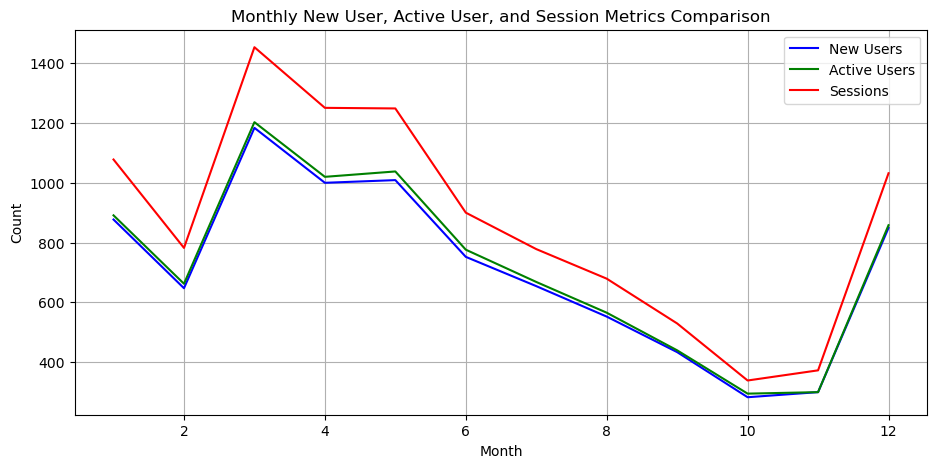

In [6]:
# Visualize 
plt.figure(figsize=(11, 5))

metrics = ['newUsers', 'activeUsers', 'sessions']
labels  = ['New Users', 'Active Users', 'Sessions']
colors  = ['blue', 'green', 'red']

for metric, label, color in zip(metrics, labels, colors):
    plt.plot(monthly_metrics_comparison['month'], monthly_metrics_comparison[metric], label=label, color=color)

plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Monthly New User, Active User, and Session Metrics Comparison')
plt.legend()
plt.grid(True)
plt.show()

- New users: The number of users who interacted with your site or launched your app for the first time (event triggered: first_open or first_visit). 

- Active users: The number of distinct users who visited your site or app.

- Sessions: The number of sessions that began on your site or app (event triggered: session_start).

## Top 5 Landing Pages by Active Users

In [7]:
# Run report
landing_page_users_request = RunReportRequest(
        property='properties/'+property_id,
        dimensions=[Dimension(name="landingPage")],
        metrics=[Metric(name="activeUsers"),
                 Metric(name="bounceRate")],
        order_bys = [OrderBy(dimension = {'dimension_name': 'activeUsers'}, desc=True)],
        date_ranges=[DateRange(start_date="2022-11-19", end_date="today")],
    )

landing_page_users_request

property: "properties/343225696"
dimensions {
  name: "landingPage"
}
metrics {
  name: "activeUsers"
}
metrics {
  name: "bounceRate"
}
date_ranges {
  start_date: "2022-11-19"
  end_date: "today"
}
order_bys {
  dimension {
    dimension_name: "activeUsers"
  }
  desc: true
}

In [8]:
landing_table = format_report(landing_page_users_request)
landing_table['activeUsers'] = landing_table['activeUsers'].astype('int')

print('\nTop 15 Landing Pages and, its Bounce Rate')
display(landing_table[0:15]) 


Top 15 Landing Pages and, its Bounce Rate


,activeUsers,bounceRate
landingPage,,
/2021/06/02/mail-nasil-yazilir,1242,0.251759
/2019/12/29/nedir-bu-aiesec,956,0.131899
/2020/02/22/erasmus-staj-programi-hollanda,950,0.145038
/2021/02/07/europass-cv-nasil-hazirlanir,916,0.098646
/2020/02/26/erasmus-programi-romanya,846,0.126687
(not set),556,0.896277
/2020/04/29/erasmus-staj-programi-ingiltere,422,0.152838
/2021/04/25/motivasyon-mektubu-nasil-yazilir,406,0.116631
,324,0.702179


- Landing page: The page path associated with the first pageview in a session.

- Bounce rate: The percentage of sessions that were not engaged ((Sessions Minus Engaged sessions) divided by Sessions). This metric is returned as a fraction; for example, 0.2761 means 27.61% of sessions were bounces.

## Events Comparison

In [9]:
# Run report
event_request = RunReportRequest(
        property='properties/'+property_id,
        dimensions=[Dimension(name="eventName")],
        metrics=[Metric(name="activeUsers")],
        order_bys = [OrderBy(dimension = {'dimension_name': 'activeUsers'}, desc=True)],
        date_ranges=[DateRange(start_date="2022-11-19", end_date="today")],
    )

event_request

property: "properties/343225696"
dimensions {
  name: "eventName"
}
metrics {
  name: "activeUsers"
}
date_ranges {
  start_date: "2022-11-19"
  end_date: "today"
}
order_bys {
  dimension {
    dimension_name: "activeUsers"
  }
  desc: true
}

In [10]:
event_comparison = format_report(event_request)

# Export & load the data
event_comparison.reset_index().to_excel('event_comparison.xlsx', sheet_name = 'GA4_report_event', engine = 'xlsxwriter')
event_comparison = pd.read_excel('event_comparison.xlsx')

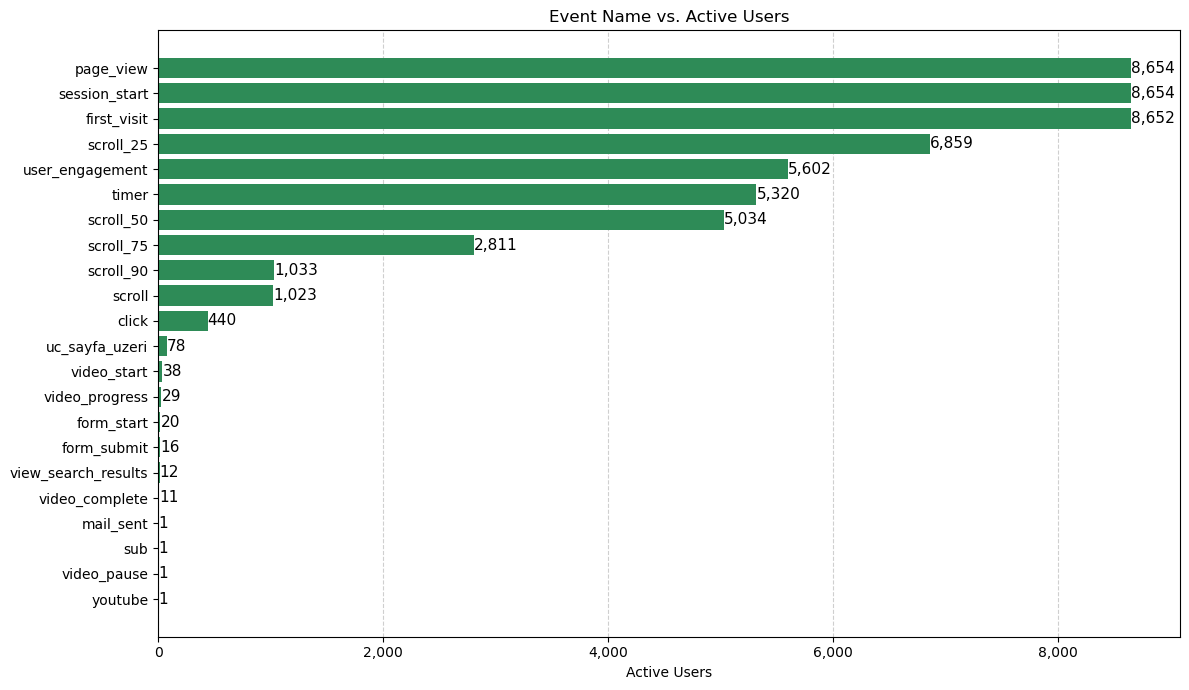

In [11]:
event_names = event_comparison['eventName']
active_users = event_comparison['activeUsers']

fig, ax = plt.subplots(figsize=(12, 7))
bars = ax.barh(event_names, active_users, color='seagreen')

for bar, value in zip(bars, active_users):
    ax.text(value, bar.get_y() + bar.get_height() / 2, f'{value:,}', va='center', fontsize=11, color='black')

plt.xlabel('Active Users')
plt.title('Event Name vs. Active Users')
plt.gca().invert_yaxis()

ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
ax.xaxis.grid(True, linestyle='--', alpha=0.6)
ax.set_axisbelow(True)

plt.tight_layout()

plt.show()

## Monthly Traffic Chart

In [12]:
# Run report
traffic_request = RunReportRequest(
        property='properties/'+property_id,
        dimensions=[Dimension(name="month"), 
                    Dimension(name="sessionMedium")],
        metrics=[Metric(name="averageSessionDuration"), 
                 Metric(name="activeUsers")],
        order_bys = [OrderBy(dimension = {'dimension_name': 'month'}),
                    OrderBy(dimension = {'dimension_name': 'sessionMedium'})],
        date_ranges=[DateRange(start_date="2022-06-01", end_date="today")],
    )

traffic_request

property: "properties/343225696"
dimensions {
  name: "month"
}
dimensions {
  name: "sessionMedium"
}
metrics {
  name: "averageSessionDuration"
}
metrics {
  name: "activeUsers"
}
date_ranges {
  start_date: "2022-06-01"
  end_date: "today"
}
order_bys {
  dimension {
    dimension_name: "month"
  }
}
order_bys {
  dimension {
    dimension_name: "sessionMedium"
  }
}

In [13]:
monthly_trafficChart = format_report(traffic_request)

monthly_users_pivot = pd.pivot_table(monthly_trafficChart, 
                                     columns=['sessionMedium'], 
                                     index=['month'], 
                                     values=['activeUsers'], 
                                     aggfunc = 'sum',
                                     fill_value=0).droplevel(0, axis=1)

monthly_users_pivot

sessionMedium,(none),(not set),organic,referral
month,,,,
01,79,1,791,20
02,57,0,591,14
03,72,0,1111,20
04,46,0,954,21
05,63,0,950,26
06,41,3,716,18
07,40,1,612,16
08,46,1,508,13
09,38,0,386,16


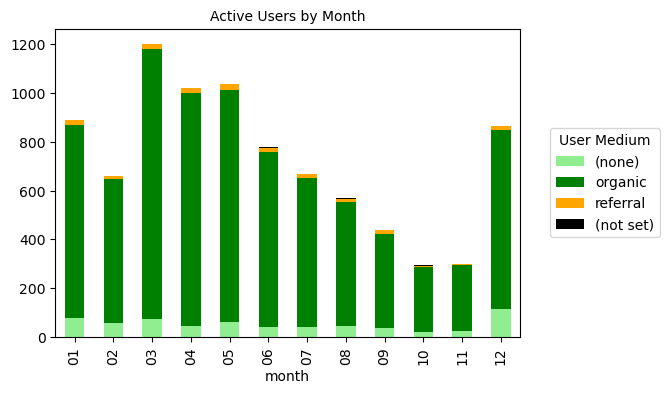

In [14]:
custom_colors = ['lightgreen', 'green', 'orange', 'black']
ax = monthly_users_pivot[['(none)', 'organic', 'referral', '(not set)']].plot(kind='bar', stacked=True,
                                                                         color=custom_colors,
                                                                         figsize=(6, 4))
ax.set_title('Active Users by Month', fontsize=10)
ax.legend(title='User Medium', bbox_to_anchor=(1.05, 0.7))

plt.show()

- Medium: The type of traffic.

## Device model, Age and, Gender 

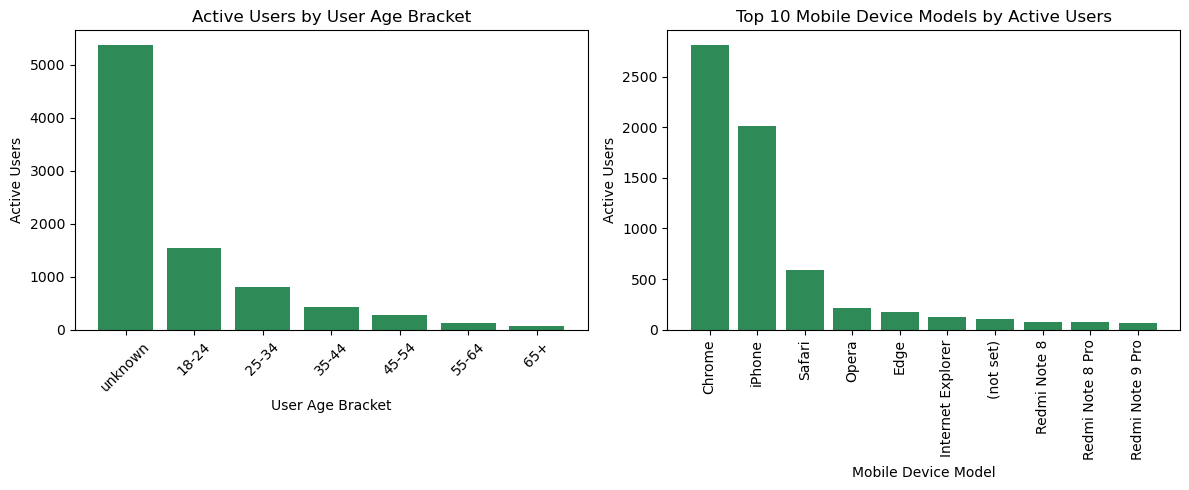

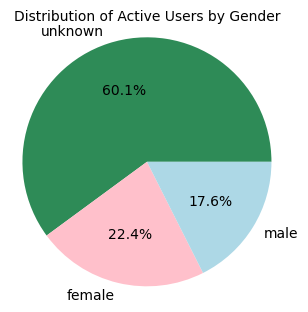

In [15]:
# Report request

mobileDeviceModel_request = RunReportRequest(
        property='properties/'+property_id,
        dimensions=[Dimension(name="mobileDeviceModel")],
        metrics=[Metric(name="activeUsers")],
        order_bys = [OrderBy(dimension = {'dimension_name': 'activeUsers'}, desc=True)],
        date_ranges=[DateRange(start_date="2022-11-19", end_date="today")],
    )

userAgeBracket_request = RunReportRequest(
        property='properties/'+property_id,
        dimensions=[Dimension(name="userAgeBracket")],
        metrics=[Metric(name="activeUsers")],
        order_bys = [OrderBy(dimension = {'dimension_name': 'activeUsers'}, desc=True)],
        date_ranges=[DateRange(start_date="2022-11-19", end_date="today")],
    ) 

userGender_request = RunReportRequest(
        property='properties/'+property_id,
        dimensions=[Dimension(name="userGender")],
        metrics=[Metric(name="activeUsers")],
        order_bys = [OrderBy(dimension = {'dimension_name': 'activeUsers'}, desc=True)],
        date_ranges=[DateRange(start_date="2022-11-19", end_date="today")],
    ) 

mobileDeviceModel = format_report(mobileDeviceModel_request)
userAgeBracket = format_report(userAgeBracket_request)
gender = format_report(userGender_request)


# Export & load the data

mobileDeviceModel.reset_index().to_excel('mobileDeviceModel.xlsx', sheet_name = 'GA4_report_mobileDeviceModel', engine = 'xlsxwriter')
mobileDeviceModel = pd.read_excel('mobileDeviceModel.xlsx')

userAgeBracket.reset_index().to_excel('userAgeBracket.xlsx', sheet_name = 'GA4_report_userAgeBracket', engine = 'xlsxwriter')
userAgeBracket = pd.read_excel('userAgeBracket.xlsx')

gender.reset_index().to_excel('gender.xlsx', sheet_name = 'GA4_report_gender', engine = 'xlsxwriter')
gender = pd.read_excel('gender.xlsx')


# Visualization

plt.figure(figsize=(12, 5)) 

plt.subplot(1, 2, 1)
plt.bar(userAgeBracket['userAgeBracket'], userAgeBracket['activeUsers'], color='seagreen')
plt.xlabel('User Age Bracket')
plt.ylabel('Active Users')
plt.title('Active Users by User Age Bracket')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
top_10_mobile_models = mobileDeviceModel.nlargest(10, 'activeUsers')
plt.bar(top_10_mobile_models['mobileDeviceModel'], top_10_mobile_models['activeUsers'], color='seagreen')
plt.xlabel('Mobile Device Model')
plt.ylabel('Active Users')
plt.title('Top 10 Mobile Device Models by Active Users')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

def create_pie_chart(data, labels, title, title_size=14):
    plt.figure(figsize=(3.2, 3.2))
    plt.pie(data['activeUsers'], labels=labels, autopct='%1.1f%%', colors=['seagreen', 'pink', 'lightblue'])
    plt.title(title, fontsize=title_size) 
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

create_pie_chart(gender, gender['userGender'], 'Distribution of Active Users by Gender', title_size=10)